# Implementation of Policy Iteration Algorithm

The algorithm is composed of two sub-algorithms : Policy Evaluation and Policy Improvement. By iteratively executing these algorithms until the policy converges, we are ensured to find optimal policy and values for a given MDP.

### Imports

In [1]:
import jax
import jax.numpy as jnp

from mdp import MDP
from mdp import visualize_policy_and_values

### Define a MDP

In [2]:
# create the MDP
mdp = MDP.create()

# initialize random keys for policy and value generation
key = jax.random.PRNGKey(0)
key, v_key, p_key = jax.random.split(key, 3)

# hyperparameters for RL algorithm
gamma = 0.9 # discount factor
theta=1e-5 # convergence threshold for policy evaluation

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


The mdp contains : 

- states S
- actions A
- transition probabilities P(s'|s,a)
- rewards R(s', a, s)

In [3]:
mdp.infos()

MDP infos:
S: [0 1 2 3 4 5 6 7 8]
A: [0 1 2 3]
P(s'|s,a).shape: (9, 4, 9)
R(s', a, s).shape: (9, 4, 9)


### Implement Policy Evaluation

Policy evaluation enables updating the value function given the current policy.

In [4]:
def policy_evaluation(policy, values, theta):
    """Update the value function given the current policy

    :param policy: current policy
    :param values: current values
    :param theta: convergence threshold
    :return: updated values
    """
    def body_fn(values_delta):
        values, delta = values_delta
        # initialize new values and new delta
        new_values = jnp.zeros((values.shape))
        delta = 0
        # iterate over all states
        for s in mdp.states:
            # get policy action, and associated transition probabilities and rewards
            action = policy[s]
            p_transition = mdp.transition_probabilities[s, action]
            rewards = mdp.rewards[s, action]
            # sum the expected returns for all states s', knowing current s and a
            value = jnp.sum(p_transition * (rewards + gamma * values))
            # update delta and set the new value
            delta = jnp.maximum(delta, jnp.abs(value - values[s]))
            new_values = new_values.at[s].set(value)

        return (new_values, delta)
        
    def cond_fn(vals_delta):
        # check if delta < theta (convergence)
        values, delta = vals_delta
        # we return delta > theta because we want the loop to continue if it is the case
        return delta > theta
    
    # set intial delta to inf so we ensure the 1st cond fn is True
    initial_vals_delta = (values, jnp.inf)
    # use jax.while loop with the condition and body functions defined above (while cond is True, do body)
    vals_delta = jax.lax.while_loop(cond_fn, body_fn, initial_vals_delta)
    values, _ = vals_delta
    return values

### Implement Policy Improvement

Policy improvement enables updating the policy given the current value function.

In [5]:
def policy_improvement(policy, values):
    """Update the policy given the current value function

    :param policy: current policy
    :param values: current values
    :return: updated policy
    """
    # init new policy
    new_policy = jnp.zeros((policy.shape), dtype=int)
    # iterate over all states
    for s in mdp.states:
        # evaluate all actions for a given state
        evals = jnp.zeros((mdp.actions.shape))
        for a in mdp.actions:
            p_transition = mdp.transition_probabilities[s, a]
            rewards = mdp.rewards[s, a]
            # sum the expected return for all states s'
            eval = jnp.sum(p_transition * (rewards + gamma * values))
            evals = evals.at[a].set(eval)
        # choose the action that yields the highest expected returns and update the policy
        best_action = jnp.argmax(evals)
        new_policy = new_policy.at[s].set(best_action)
    return new_policy

### Implement Policy Iteration

In [6]:
@jax.jit
def policy_iteration(initial_policy, initial_values, theta):
    """Iteratively apply Policy Evaluation and Policy Improvement until policy converges

    :param initial_policy: initial_policy
    :param initial_values: initial_values
    :param theta: convergence threshold
    :return: optimal policy, optimal values
    """
    policy = initial_policy
    values = initial_values
    
    def body_fn(old_p_new_p_values):
        # do 1 iteration of policy evaluation and improvement
        old_policy, policy, values = old_p_new_p_values
        old_policy = jnp.copy(policy)
        values = policy_evaluation(policy, values, theta)
        policy = policy_improvement(policy, values)
        # return the old policy, the updated one and the new values
        return (old_policy, policy, values)

    def cond_fn(old_p_new_p_values):
        # return true if the policies are different to keep iterating
        old_policy, policy, values = old_p_new_p_values
        return jnp.any(old_policy != policy)
    
    # do a slight modification to the initial policy so the cond_fn isn't false at 1st iteration
    old_policy = initial_policy + 1 
    init_values = (old_policy, policy, values)
    old_policy, policy, values = jax.lax.while_loop(cond_fn, body_fn, init_values)

    return policy, values


#### Define a random Value function and a random Policy and visualize them

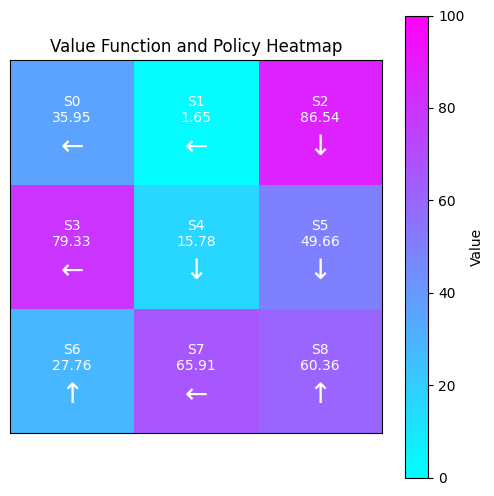

In [7]:
key = jax.random.PRNGKey(0)
key, v_key, p_key = jax.random.split(key, 3)

values = jax.random.uniform(v_key, shape=(mdp.states.shape), minval=0, maxval=100)
policy = jax.random.randint(p_key, shape=(mdp.states.shape), minval=jnp.min(mdp.actions), maxval=jnp.max(mdp.actions))
visualize_policy_and_values(policy, values)

#### Apply Policy Iteration and visualize the updated Policy and Values

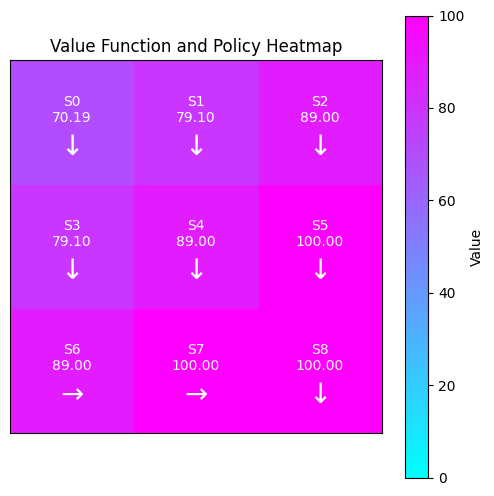

In [8]:
policy, values = policy_iteration(policy, values, theta=1e-5)
visualize_policy_and_values(policy, values)